# Prediction of the movie revenue

### This dataset *movies_new.csv* can be downloaded from Google drive: https://drive.google.com/drive/folders/1MwFoUvUp2St0Sjq0I9dlNIl_BXkw3fZU

In [1]:
# import the library
%matplotlib inline

import ast
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

    
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# apply style to all the charts
sns.set_style('whitegrid')

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 24)

# Reading the Data

In [2]:
df = pd.read_csv('data/movies_new.csv')
#df = pd.read_csv('data/movies.csv')
df['release_date'] = pd.to_datetime(df['release_date'])
print(df.dtypes)

id                                int64
title                            object
budget                            int64
revenue                         float64
production_countries             object
release_date             datetime64[ns]
popularity                      float64
vote_average                    float64
vote_count                      float64
genres                           object
production_companies             object
belongs_to_collection            object
cast                             object
keywords                         object
dtype: object


In [3]:
#Setting cast, production_companies, genres and keywords types to a list of dictionaries

df['genres'] = df['genres'].astype(str)
df['production_companies'] = df['production_companies'].astype(str)
df['cast'] = df['cast'].astype(str)
df['keywords'] = df['keywords'].astype(str)
df['production_countries'] = df['production_countries'].astype(str)
# df['belongs_to_collection'] = df['belongs_to_collection'].astype(str)

df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))
df['production_companies'] = df['production_companies'].apply(lambda x: ast.literal_eval(x))
df['cast'] = df['cast'].apply(lambda x: ast.literal_eval(x))
df['keywords'] = df['keywords'].apply(lambda x: ast.literal_eval(x))
df['production_countries'] = df['production_countries'].apply(lambda x: ast.literal_eval(x))
# df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: ast.literal_eval(x))

Some adjustments

In [4]:
#Extra adjustments for the points discovered later during the process

#replace FRF budget by USD
df.loc[df['id'] == 10656, ['budget']] = 25974
print(df.loc[df['id'] == 10656, ['title']])

#wrong revenue
df.loc[df['id'] == 9838, ['revenue']] = 15057465
print(df.loc[df['id'] == 9838, ['title']])

       title
2134  Subway
                     title
1242  King Solomon's Mines


In [5]:
# Analize release date
# We see that there is a strong tendency of grouth movies produced every year
df['year'] = df['release_date'].dt.year
df['year_month'] = pd.to_datetime(df['release_date']).dt.to_period('M')

### Choosing time period

In [6]:
#Slicing our data 

df = df[(df['year']>=2000) & (df['year']<2017)]

print(df.shape)

(3044, 16)


In [7]:
df.head(5)

,id,title,budget,revenue,production_countries,release_date,popularity,vote_average,vote_count,genres,production_companies,belongs_to_collection,cast,keywords,year,year_month
3,121173,Voracious,11178,34659.000,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2012-09-05,0.079,8.000,1.000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'APT Entertainment', 'id': 8355}, {'...",0,"[{'cast_id': 16, 'character': 'Rene', 'credit_...","[{'id': 4694, 'name': 'staged death'}, {'id': ...",2012,2012-09
5,110428,Camille Claudel 1915,3512454,115860.000,"[{'iso_3166_1': 'FR', 'name': 'France'}]",2013-03-13,0.110,7.000,20.000,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03
6,110428,Camille Claudel 1915,3512454,115860.000,"[{'iso_3166_1': 'FR', 'name': 'France'}]",2013-03-13,0.110,7.000,20.000,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03
7,110428,Camille Claudel 1915,3512454,115860.000,"[{'iso_3166_1': 'FR', 'name': 'France'}]",2013-03-13,0.110,7.000,20.000,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03
8,110428,Camille Claudel 1915,3512454,115860.000,"[{'iso_3166_1': 'FR', 'name': 'France'}]",2013-03-13,0.110,7.000,20.000,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03


Kepping only movies which were produced in USA as the budget might be marked in US although in reality its not 

In [8]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value in item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of countries
l=[]
for i, item in enumerate(df['production_countries']):
    for cell in item:
        l.append(cell['name'])
p_name, p_count = np.unique(np.array(l), return_counts=True)

prod = zip(p_name, p_count) # list of Unique Values along with occurrence Count
prod = list(prod)
prod = sorted(prod, key = lambda x: x[1], reverse = True)
print('Number of production countries: ', len(prod))

df = df.iloc[index_extractor(df, 'production_countries', 'United States of America'),:]

print(df.shape)



Number of production countries:  68
(2464, 16)


# Choosing the columns

In [9]:

X = df[['title', 'budget', 'year', 'genres', 'production_companies', 'revenue',  'vote_count', 'vote_average',
        'belongs_to_collection', 'cast']]
# y = df['revenue']
# X = X.reset_index(drop=True)
# y = y.reset_index(drop=True)

# Feature engineering

### Budget

C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(array([  3.,   4.,  14.,  22.,  47., 126., 395., 947., 697., 209.]),
 array([ 8.85366543,  9.94386707, 11.0340687 , 12.12427034, 13.21447198,
        14.30467362, 15.39487526, 16.4850769 , 17.57527853, 18.66548017,
        19.75568181]),
 <a list of 10 Patch objects>)

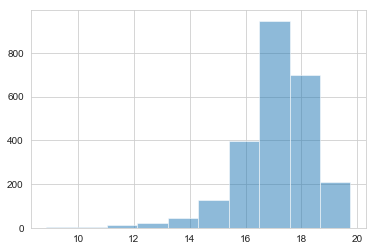

In [10]:
#plt.hist(X['budget'], alpha=0.5)
#print(X.groupby('budget')['id'].count())

X['budget'] = np.log(X['budget'])
plt.hist(X['budget'], alpha=0.5)

Removing outliers

In [11]:
# print(X['budget'].describe())

# mean_a = np.mean(X['budget'])
# std_a = np.std(X['budget'])

# X = X[(X['budget']>mean_a-3*std_a)&(X['budget']<mean_a+3*std_a)]

# print('After removing outliers:')
# print(X['budget'].describe())

# plt.figure()
# plt.hist(X['budget'])
# plt.show

### Revenue

(array([2.144e+03, 1.970e+02, 7.300e+01, 3.700e+01, 7.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1.40400000e+03, 2.78797772e+08, 5.57594141e+08, 8.36390509e+08,
        1.11518688e+09, 1.39398325e+09, 1.67277961e+09, 1.95157598e+09,
        2.23037235e+09, 2.50916872e+09, 2.78796509e+09]),
 <a list of 10 Patch objects>)

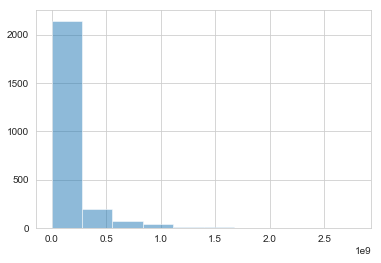

In [12]:
#plt.hist(X['revenue'])

#X['revenue'] = np.log(X['revenue'])
plt.hist(X['revenue'], alpha=0.5)

Removing outliers

In [13]:
# print(X['revenue'].describe())

# mean_a = np.mean(X['revenue'])
# std_a = np.std(X['revenue'])

# X = X[(X['revenue']>mean_a-3*std_a)&(X['revenue']<mean_a+3*std_a)]

# print('After removing outliers:')
# print(X['revenue'].describe())

# plt.figure()
# plt.hist(X['revenue'])
# plt.show

### Vote count

Removed from prediction as we wont be able to input this feature in our API

In [14]:
# plt.hist(X['vote_count'], bins=50)

### Vote average

Removed from prediction as we wont be able to input this feature in our API

In [15]:
# plt.hist(X['vote_average'], bins=50)

Removing outliers

In [16]:
# print(X['vote_average'].describe())

# mean_a = np.mean(X['vote_average'])
# std_a = np.std(X['vote_average'])

# X = X[(X['vote_average']>mean_a-3*std_a)&(X['vote_average']<mean_a+3*std_a)]

# print('After removing outliers:')
# print(X['vote_average'].describe())

# plt.figure()
# plt.hist(X['vote_average'])
# plt.show

### Popularity

Removed from prediction as this feature showed to be changing with the time. It depends on the current interest of public to the movie. I means that the most popular movies in this dataset are the ones that were released right before extracting the data 

In [17]:
# plt.hist(X['popularity'])

Removing outliers

In [18]:

# print(X['popularity'].describe())

# mean_a = np.mean(X['popularity'])
# std_a = np.std(X['popularity'])

# X = X[(X['popularity']>mean_a-3*std_a)&(X['popularity']<mean_a+3*std_a)]

# print('After removing outliers:')
# print(X['popularity'].describe())

# plt.figure()
# plt.hist(X['popularity'])
# plt.show

### Belongs_to_collection

In [19]:
coll = [0 if col == '0' else 1 for col in X['belongs_to_collection']]
X['collection'] = coll
# del X['belongs_to_collection']

C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Creating a new volumn: average of the of number of votes of all movies in each collection. And assigning this values to the movies which belongs to the collection. Here number of votes will be the measure of movie popularity (more votes - higher popularity). As we've learned that popularity feature doesn't reflect real picture as it is mesured in a timely manner (older movies are not popular as now people are not checking them out on IMDB)

In [20]:
X.reset_index(inplace=True, drop=True)
df['belongs_to_collection'] = df['belongs_to_collection'].astype(str)

index_extractor = lambda df, field, value: [idx for idx, item in enumerate(df[field]) if value == item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of collections
l=[]
index_0 = []
for i, item in enumerate(X['belongs_to_collection']):
    if item.strip() != '0':
        item = ast.literal_eval(item)
        l.append(item['name'])
    else:
        index_0.append(i)

d = {"id": 0, "name": 'No Name', "poster_path": None, "backdrop_path": None}
X['belongs_to_collection'] = [d if idx in index_0 else ast.literal_eval(item) for idx, item in enumerate(X['belongs_to_collection'])]

c_name, c_count = np.unique(np.array(l), return_counts=True)

# collection = zip(c_name, c_count) # list of collections with num of movies and average popularity
# collection = list(collection)
# collection = sorted(collection, key = lambda x: x[1], reverse = True)
# c_name=[]
# c_count=[]
# for i in range(len(collection)):
#     c_name.append(collection[i][0])
#     c_count.append(collection[i][1])

#Creating mean count_votes for each collection
index_extractor = lambda df, field, value: [idx for idx, item in enumerate(df['belongs_to_collection']) if type(item) != str if coll == item['name']]
list_pop_creator =  lambda df, idx: [df.loc[i,'vote_count'] if i in idx else 0 for i in df.index] # List of popularities for current actor

X['coll_vote'] = [0 for i in range(len(X.index))]

c_pop = []
for coll, count in zip(c_name, c_count):
    idx = index_extractor(X, 'belongs_to_collection', coll)
    list_pop = list_pop_creator(X, idx) 
    vote_count_ave = (np.sum(list_pop)/count) 
    X['coll_vote'] = [vote_count_ave if i in idx else item for i, item in enumerate(X['coll_vote'])]

    c_pop.append(vote_count_ave)
del X['belongs_to_collection']



C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

Exporting these features for external usage

In [21]:
df_collection = pd.DataFrame(data=[c_name, c_pop]).T
df_collection.columns=['name', 'vote_count']
df_collection = df_collection.sort_values(by='vote_count',ascending=False)
df_collection.reset_index(drop=True, inplace=True)
df_collection.to_csv('data/collections.csv', index=False)
df_collection.head(10)

,name,vote_count
0,Avatar Collection,12114.000
1,Deadpool Collection,11444.000
2,Guardians of the Galaxy Collection,10014.000
3,The Dark Knight Collection,9681.000
4,Mad Max Collection,9629.000
5,The Avengers Collection,9454.000
6,Iron Man Collection,8290.333
7,The Lord of the Rings Collection,8253.000
8,Captain America Collection,6839.000
9,Man of Steel Collection,6825.500


### Genres

In [22]:
X.reset_index(inplace=True, drop=True)
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of genres
l=[]
for i, item in enumerate(X['genres']):
    for cell in item:
        l.append(cell['name'])
g_name, g_count = np.unique(np.array(l), return_counts=True)

# Create column for every genre and assigh 1 or 0
for genre in g_name:
    idx = index_extractor(X, 'genres', genre)
    c = list_creator(X, idx)
    genre_col = pd.Series(c)    
    X = X.assign(genre_col=genre_col.values)
    X.rename(columns={'genre_col':'{0}'.format(genre)}, inplace=True)

Creating new features: average vote number, average vote and ave revenue of the genres of each movie

In [23]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_vote_count_creator =  lambda df, idx: [df.loc[i,'vote_count'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_vote_ave_creator =  lambda df, idx: [df.loc[i,'vote_average'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_rev_creator =  lambda df, idx: [df.loc[i,'revenue'] if i in idx else 0 for i in df.index] # List of popularities for current actor

X['g_vote_count'] = [0 for i in range(len(X.index))]
X['g_vote_ave'] = [0 for i in range(len(X.index))]
X['g_rev_ave'] = [0 for i in range(len(X.index))]

g_pop = []
g_vote = []
g_rev = []
for genre, count in zip(g_name, g_count):
    idx = index_extractor(X, 'genres', genre)
    
    list_vote_count = list_vote_count_creator(X, idx) 
    list_vote_ave = list_vote_ave_creator(X, idx) 
    list_rev_ave = list_rev_creator(X, idx) 
    
    vote_count_ave = (np.sum(list_vote_count)/count)
    vote_ave = (np.sum(list_vote_ave)/count)
    rev_ave = (np.sum(list_rev_ave)/count)
    
    g_pop.append(vote_count_ave)
    g_vote.append(vote_ave)
    g_rev.append(rev_ave)

    X['g_vote_count'] = [item + vote_count_ave if i in idx else item for i, item in enumerate(X['g_vote_count'])]
    X['g_vote_ave'] = [item + vote_ave if i in idx else item for i, item in enumerate(X['g_vote_ave'])]
    X['g_rev_ave'] = [item + rev_ave if i in idx else item for i, item in enumerate(X['g_rev_ave'])]

genres = zip(g_name, g_pop, g_vote, g_rev) # to export to API

del X['genres']

Exporting these features for external usage

In [24]:
df_genre = pd.DataFrame(data=[g_name, g_pop, g_vote, g_rev]).T
df_genre.columns=['name', 'vote_count', 'vote_average', 'revenue']
df_genre = df_genre.sort_values(by='revenue',ascending=False)
df_genre.reset_index(drop=True, inplace=True)
df_genre.to_csv('data/genres.csv', index=False)
df_genre.head(10)

,name,vote_count,vote_average,revenue
0,Animation,1628.479,6.333,313688085.455
1,Fantasy,2103.510,6.122,312093050.061
2,Adventure,2160.680,6.179,307312994.866
3,Family,1401.189,6.120,267541190.492
4,Science Fiction,2162.290,6.038,234570773.980
5,Action,1768.320,6.053,208239482.198
6,Comedy,834.353,5.981,117398098.137
7,War,1075.676,6.521,111977869.132
8,Thriller,1103.845,6.057,107607849.905
9,Western,1538.962,6.435,103943122.423


In [25]:
X.head()

,title,budget,year,production_companies,revenue,vote_count,vote_average,cast,collection,coll_vote,Action,Adventure,...,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,g_vote_count,g_vote_ave,g_rev_ave
0,Cruel World,14.509,2005,"[{'name': 'Primetime Pictures', 'id': 36417}, ...",16344.000,6.000,4.800,"[{'cast_id': 1, 'character': 'Philip Markham',...",0,0.000,0,0,...,0,1,0,0,0,0,1,0,0,2649.841,17.626,293907207.151
1,Behind the Burly Q,12.429,2010,"[{'name': 'Mistress Inc.', 'id': 38568}]",23859.000,3.000,5.500,"[{'cast_id': 2, 'character': '. Himself (arc...",0,0.000,0,0,...,0,0,0,0,0,0,0,0,0,152.667,6.700,27019585.481
2,The Internship,17.876,2013,[{'name': 'Twentieth Century Fox Film Corporat...,44000000.000,1691.000,6.100,"[{'cast_id': 7, 'character': 'Nick Campbell', ...",0,0.000,0,0,...,0,0,0,0,0,0,0,0,0,834.353,5.981,117398098.137
3,Resident Evil: Afterlife,17.910,2010,"[{'name': 'Impact Pictures', 'id': 248}, {'nam...",300228084.000,1382.000,5.800,"[{'cast_id': 11, 'character': 'Alice', 'credit...",1,1538.800,1,1,...,0,1,0,0,0,1,0,0,0,6802.934,23.857,819024510.153
4,Eye of the Dolphin,14.732,2007,"[{'name': 'Gold/Miller Productions', 'id': 160...",71904.000,7.000,7.100,"[{'cast_id': 1, 'character': 'Alyssa', 'credit...",1,7.000,0,0,...,0,0,0,0,0,0,0,0,0,857.689,6.435,80589943.807


### Production Companies

In [26]:
X.reset_index(inplace=True, drop=True)
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of production_companies
l=[]
for i, item in enumerate(X['production_companies']):
    for cell in item:
        l.append(cell['name'])
p_name, p_count = np.unique(np.array(l), return_counts=True)

prod = zip(p_name, p_count) # list of Unique Values along with occurrence Count
prod = list(prod)
prod = sorted(prod, key = lambda x: x[1], reverse = True)
print('Number of production companies: ', len(prod))
    
#100 companies which produced the hihest number of movies
p_name = []
p_count = []
for i in range(100):
    p_name.append(prod[i][0])
    p_count.append(prod[i][1])


Number of production companies:  2903


In [27]:
# s = '"", '
# for i in sorted(p_name):
#     s = s + '"' + i + '", '
# print(s)

In [28]:
len(p_name)

100

In [29]:
# Create column for every production companie and assigh 1 or 0
for p_n in p_name:
    idx = index_extractor(X, 'production_companies', p_n)
    c = list_creator(X, idx)
    prod_col = pd.Series(c)    
    X = X.assign(prod_col=prod_col.values)
    X.rename(columns={'prod_col':'{0}'.format(p_n)}, inplace=True)


Create new features

In [30]:
# Reassign to p_name all of the companies
p_name = []
p_count = []
for i in range(len(prod)):
    p_name.append(prod[i][0])
    p_count.append(prod[i][1])

In [31]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_vote_count_creator =  lambda df, idx: [df.loc[i,'vote_count'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_vote_ave_creator =  lambda df, idx: [df.loc[i,'vote_average'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_rev_creator =  lambda df, idx: [df.loc[i,'revenue'] if i in idx else 0 for i in df.index] # List of popularities for current actor

X['p_vote_count'] = [0 for i in range(len(X.index))]
X['p_vote_ave'] = [0 for i in range(len(X.index))]
X['p_rev_ave'] = [0 for i in range(len(X.index))]

p_pop = []
p_vote = []
p_rev = []
for prod, count in zip(p_name, p_count):
    idx = index_extractor(X, 'production_companies', prod)
    
    list_vote_count = list_vote_count_creator(X, idx) 
    list_vote_ave = list_vote_ave_creator(X, idx) 
    list_rev_ave = list_rev_creator(X, idx) 
    
    vote_count_ave = (np.sum(list_vote_count)/count)
    vote_ave = (np.sum(list_vote_ave)/count)
    rev_ave = (np.sum(list_rev_ave)/count)
    
    p_pop.append(vote_count_ave)
    p_vote.append(vote_ave)
    p_rev.append(rev_ave)

    X['p_vote_count'] = [item + vote_count_ave if i in idx else item for i, item in enumerate(X['p_vote_count'])]
    X['p_vote_ave'] = [item + vote_ave if i in idx else item for i, item in enumerate(X['p_vote_ave'])]
    X['p_rev_ave'] = [item + rev_ave if i in idx else item for i, item in enumerate(X['p_rev_ave'])]

del X['production_companies']


Exporting these features for external usage

In [32]:
df_prod = pd.DataFrame(data=[p_name, p_pop, p_vote, p_rev]).T
df_prod.columns=['name', 'vote_count', 'vote_average', 'revenue']
df_prod = df_prod.sort_values(by='revenue',ascending=False)
df_prod.reset_index(drop=True, inplace=True)
df_prod.to_csv('data/prod_companies.csv', index=False)
df_prod.head(10)

,name,vote_count,vote_average,revenue
0,Truenorth Productions,7993.000,7.500,2068223624.000
1,Abu Dhabi Film Commission,4253.000,7.300,1506249360.000
2,"Colorado Office of Film, Television & Media",4253.000,7.300,1506249360.000
3,Lightstorm Entertainment,6246.000,6.550,1408983922.500
4,Deluxe Digital Studios,7462.000,7.100,1153304495.000
5,Vita-Ray Dutch Productions (III),7462.000,7.100,1153304495.000
6,Ian Bryce Productions,3136.000,5.800,1091405097.000
7,Black Hangar Studios,5111.000,7.400,1056057273.000
8,Second Mate Productions,5003.500,6.950,1013329906.000
9,3Foot7,4884.000,7.100,956019788.000


### Cast

In [33]:
X.reset_index(inplace=True, drop=True)
#Extracting list of actors
l=[]
for i, item in enumerate(X['cast']):
    for cell in item:
        l.append(cell['name'])
a_name, a_count = np.unique(np.array(l), return_counts=True)
idx=[]
for i, item  in enumerate(a_name):
    if (item == 'Kar') | (item == 'George') | (a_name[i] == 'Mario') | (a_name[i] == 'Jack') | (a_name[i] == 'Charle') | (a_name[i] == 'Charlie') | (a_name[i] == 'Mars') | (a_name[i] == 'Terry') | (a_name[i] == 'King') | (a_name[i] == 'Sim') | (a_name[i] == 'Elli') | (a_name[i] == 'Carlos') | (a_name[i] == 'Sandra') | (a_name[i] == 'Justin') | (a_name[i] == 'Shane') | (a_name[i] == 'Angela') | (a_name[i] == 'Eve') | (a_name[i] == 'Foster') | (a_name[i] == 'Take') | (a_name[i] == 'Andrea') | (a_name[i] == 'Ade') | (a_name[i] == 'Tiffany') | (a_name[i] == 'Zoë'):
        idx.append(i)
    
a_name = np.delete(a_name, idx)
a_count = np.delete(a_count, idx)

act = zip(a_name, a_count) # list of Unique Values along with occurrence Count
act = list(act)
act = sorted(act, key = lambda x: x[1], reverse = True)
print('Number of actors: ', len(act))

#100 companies which produced the hihest number of movies
a_name = []
a_count = []

for i in range(len(act)):
    if act[i][1] > 20:
        a_name.append(act[i][0])
        a_count.append(act[i][1])

        
print(len(a_name), len(a_count))

Number of actors:  35593
108 108


In [34]:
# s = '"", '
# for i in sorted(a_name):
#     s = s + '"' + i + '", '
# print(s)

In [35]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]
# Create column for every actor and assigh 1 or 0
for actor in a_name:
    idx = index_extractor(X, 'cast', actor)
    c = list_creator(X, idx)
    prod_col = pd.Series(c)    
    X = X.assign(prod_col=prod_col.values)
    X.rename(columns={'prod_col':'{0}'.format(actor)}, inplace=True)


Create numeric features

In [36]:
# Reassign to a_name all of the actors
a_name = []
a_count = []

for i in range(len(act)):
    a_name.append(act[i][0])
    a_count.append(act[i][1])

In [37]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_vote_count_creator =  lambda df, idx: [df.loc[i,'vote_count'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_vote_ave_creator =  lambda df, idx: [df.loc[i,'vote_average'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_rev_creator =  lambda df, idx: [df.loc[i,'revenue'] if i in idx else 0 for i in df.index] # List of popularities for current actor

X['a_vote_count'] = [0 for i in range(len(X.index))]
X['a_vote_ave'] = [0 for i in range(len(X.index))]
X['a_rev_ave'] = [0 for i in range(len(X.index))]

a_pop = []
a_vote = []
a_rev = []
for actor, count in zip(a_name, a_count):
    idx = index_extractor(X, 'cast', actor)
    
    list_vote_count = list_vote_count_creator(X, idx) 
    list_vote_ave = list_vote_ave_creator(X, idx) 
    list_rev_ave = list_rev_creator(X, idx) 
    
    vote_count_ave = (np.sum(list_vote_count)/count)
    vote_ave = (np.sum(list_vote_ave)/count)
    rev_ave = (np.sum(list_rev_ave)/count)
    
    a_pop.append(vote_count_ave)
    a_vote.append(vote_ave)
    a_rev.append(rev_ave)

    X['a_vote_count'] = [item + vote_count_ave if i in idx else item for i, item in enumerate(X['a_vote_count'])]
    X['a_vote_ave'] = [item + vote_ave if i in idx else item for i, item in enumerate(X['a_vote_ave'])]
    X['a_rev_ave'] = [item + rev_ave if i in idx else item for i, item in enumerate(X['a_rev_ave'])]

del X['cast']

Exporting

In [38]:
df_act = pd.DataFrame(data=[a_name, a_pop, a_vote, a_rev]).T
df_act.columns=['name', 'vote_count', 'vote_average', 'revenue']
df_act = df_act.sort_values(by='revenue',ascending=False)
df_act.reset_index(drop=True, inplace=True)
df_act.to_csv('data/actors.csv', index=False)
df_act.head(10)

,name,vote_count,vote_average,revenue
0,Brandon Jelkes,12114.000,7.200,2787965087.000
1,Rhian Sheehan,12114.000,7.200,2787965087.000
2,Lucy Briant,12114.000,7.200,2787965087.000
3,Jamie Harrison,12114.000,7.200,2787965087.000
4,Sara Wilson,12114.000,7.200,2787965087.000
5,Mike Bodnar,12114.000,7.200,2787965087.000
6,Taylor Kibby,12114.000,7.200,2787965087.000
7,Chris Mala,12114.000,7.200,2787965087.000
8,Gerry Blair,12114.000,7.200,2787965087.000
9,Debra Wilson,12114.000,7.200,2787965087.000


In [39]:
X.head(5)

,title,budget,year,revenue,vote_count,vote_average,collection,coll_vote,Action,Adventure,Animation,Comedy,...,Michael Sheen,Paul Bettany,Peter Sarsgaard,Ron Perlman,Ryan Reynolds,Sigourney Weaver,Susan Sarandon,Tom Hanks,Tom Wilkinson,a_vote_count,a_vote_ave,a_rev_ave
0,Cruel World,14.509,2005,16344.000,6.000,4.800,0,0.000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2885.817,42.245,369186513.567
1,Behind the Burly Q,12.429,2010,23859.000,3.000,5.500,0,0.000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1102.571,33.814,126078973.857
2,The Internship,17.876,2013,44000000.000,1691.000,6.100,0,0.000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,194784.353,718.588,8688548738.102
3,Resident Evil: Afterlife,17.910,2010,300228084.000,1382.000,5.800,1,1538.800,1,1,0,0,...,0,0,0,0,0,0,0,0,0,18112.620,88.858,3057759306.850
4,Eye of the Dolphin,14.732,2007,71904.000,7.000,7.100,1,7.000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9110.383,112.585,949382564.133


# Saving to the file

In [40]:
X.head(5)
X.to_csv('data/for_api.csv', index=False)

# Prediction

In [41]:
del X['title']
del X['vote_count']
del X['vote_average']

y = X['revenue']
del X['revenue']


#X = pd.DataFrame(normalize(X, axis=0))
# for col in X.columns:
#     X[col] = StandardScaler().fit_transform(X[col].values.reshape(-1, 1))

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
X.head(5)

,budget,year,collection,coll_vote,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,Michael Sheen,Paul Bettany,Peter Sarsgaard,Ron Perlman,Ryan Reynolds,Sigourney Weaver,Susan Sarandon,Tom Hanks,Tom Wilkinson,a_vote_count,a_vote_ave,a_rev_ave
0,14.509,2005,0,0.000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2885.817,42.245,369186513.567
1,12.429,2010,0,0.000,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1102.571,33.814,126078973.857
2,17.876,2013,0,0.000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,194784.353,718.588,8688548738.102
3,17.910,2010,1,1538.800,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18112.620,88.858,3057759306.850
4,14.732,2007,1,7.000,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,9110.383,112.585,949382564.133


In [42]:
list_columns=[]
for i in X.columns:
    list_columns.append(i)
print(len(list_columns))

240


In [43]:
scores = cross_val_score(RandomForestRegressor(500), X, y, cv=10)
print('cross_val_score', np.mean(scores))

cross_val_score 0.7164881112061404


### Grid Search

In [44]:
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {
# #    'bootstrap': [True],
# #    'max_depth': [80, 90, 100, 110],
# #    'max_features': [2, 3],
# #    'min_samples_leaf': [3, 4, 5],
# #    'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 500, 1000]
# }
# # Create a based model
# rf = RandomForestRegressor()
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(X, y)
# print(grid_search.best_params_)
# print(grid_search.best_score_)
# print(grid_search.best_estimator_)

MODEL RandomForestRegressor


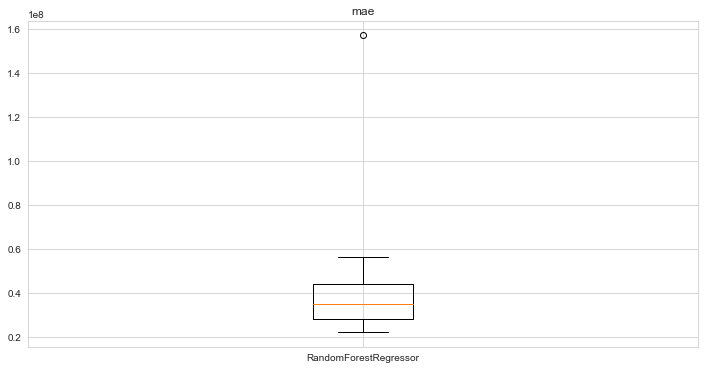

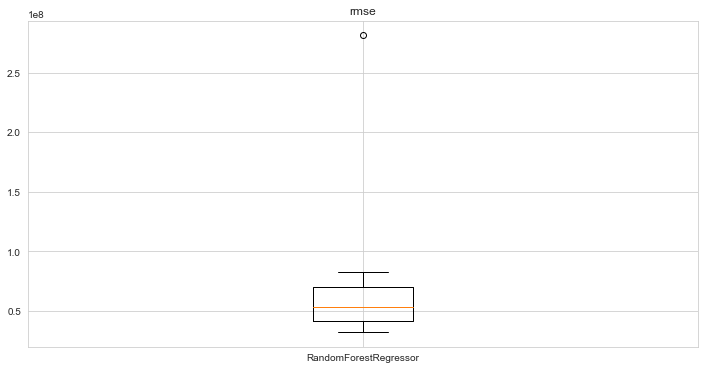

In [45]:
models = [ ('RandomForestRegressor', RandomForestRegressor(n_estimators=300, n_jobs=-1)),
           # ('Ridge Regressor', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001))
]
#('GradientBoosting', GradientBoostingRegressor()),
#('LinearRegression', LinearRegression()),
#('LassoRegressor', Lasso(alpha=0.1)),
#('RandomForestRegressor10', RandomForestRegressor(n_estimators=10)),
#('DecisionTreeRegressor', DecisionTreeRegressor())
#('KNeighborsRegressor', KNeighborsRegressor(5))

#('SVMRegressor', SVR()), - Slow - check the optimal C (find the function)
#('GaussianRegressor',GaussianProcessRegressor()),
#('SGDRegressor', SGDRegressor(), - bad results, check the parameters

k = 10
results = {}
for m in models:
    print('MODEL', m[0])
    results[m[0]] = {'mae':[], 'rmse':[]}
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X):
        X_train_k, X_test_k = X.values[train_index], X.values[test_index]
        y_train_k, y_test_k = y.values[train_index], y.values[test_index]
        model = m[1]
        model.fit(X_train_k, y_train_k.ravel())
        y_pred = model.predict(X_test_k)
        mae = mean_absolute_error(y_test_k, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_k, y_pred))
        results[m[0]]['mae'].append(mae)
        results[m[0]]['rmse'].append(rmse)
        
for metric in ['mae', 'rmse']:
    values = []
    labels = []
    for model, result_values in results.items():
        for m, v in result_values.items():
            if m == metric:
                labels.append(model)
                values.append(v)
    plt.figure(figsize=(12,6))
    plt.title(metric)
    plt.boxplot(values)
    plt.xticks(range(1, len(labels)+1), labels, rotation='horizontal')
    plt.show()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('X_train: ', X_train.shape, 'y_train:', y_train.shape, '\nX_test: ', X_test.shape, 'y_test: ', y_test.shape)
#print(X_train.head(5))
#model = LinearRegression()
model = RandomForestRegressor(500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

X_train:  (1650, 240) y_train: (1650,) 
X_test:  (814, 240) y_test:  (814,)


MAE 42006384.87642752


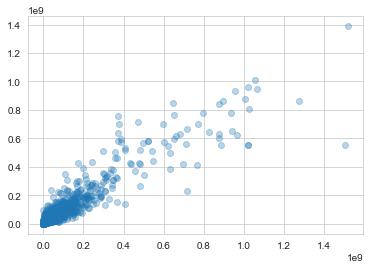

In [47]:
# Evaluate the model using the Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print('MAE', mean_absolute_error(y_test, y_pred))

# plot the results
plt.scatter(y_test, y_pred, alpha=0.3)
plt.show()

### Feature Importances

In [48]:
print(model)
fi = []
for i, col in enumerate(X_test.columns):
    fi.append([col, model.feature_importances_[i]])
features = pd.DataFrame(fi).sort_values(1, ascending=False)
print(type(features))
print(features)
useless = list(features.loc[features[1] < 0.0003, 0])
print(useless)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
<class 'pandas.core.frame.DataFrame'>
                                          0     1
239                               a_rev_ave 0.332
3                                 coll_vote 0.321
0                                    budget 0.169
238                              a_vote_ave 0.037
128                               p_rev_ave 0.020
23                             g_vote_count 0.017
237                            a_vote_count 0.013
25                                g_rev_ave 0.009
127                              p_vote_ave 0.008
1                                      year 0.007
24                       

### Error Analysis

In [49]:
df_new = pd.DataFrame(X_test).copy()
print(df_new.count())
print(len(y_pred))
df_new['revenue'] = y_test
df_new['prediction'] = y_pred
df_new['abs_error'] = abs(df_new['revenue']-df_new['prediction'])
df_new.sort_values(by='abs_error', ascending=False).round()
print(df_new.head())

budget                  814
year                    814
collection              814
coll_vote               814
Action                  814
Adventure               814
Animation               814
Comedy                  814
Crime                   814
Documentary             814
Drama                   814
Family                  814
Fantasy                 814
Foreign                 814
History                 814
Horror                  814
Music                   814
Mystery                 814
Romance                 814
Science Fiction         814
Thriller                814
War                     814
Western                 814
g_vote_count            814
g_vote_ave              814
g_rev_ave               814
Warner Bros.            814
Universal Pictures      814
Paramount Pictures      814
Columbia Pictures       814
                       ... 
Meryl Streep            814
Michael Peña            814
Robert Downey Jr.       814
Sam Rockwell            814
Steve Buscemi       

In [50]:
df_error = df_new[df_new['abs_error']>1]
#df_error.groupby()
df_error.corr()['abs_error'].dropna().sort_values()

Drama                       -0.144
Crime                       -0.084
Romance                     -0.080
Horror                      -0.080
Documentary                 -0.054
Brad Pitt                   -0.046
Focus Features              -0.045
Sam Rockwell                -0.042
FilmNation Entertainment    -0.041
Comedy                      -0.040
Western                     -0.040
History                     -0.040
EuropaCorp                  -0.040
Anonymous Content           -0.039
Metro-Goldwyn-Mayer (MGM)   -0.038
Dimension Films             -0.038
Mad Chance                  -0.036
Lionsgate                   -0.035
Epsilon Motion Pictures     -0.034
Emmett/Furla Films          -0.034
Thriller                    -0.034
Nickelodeon Movies          -0.032
Julia Roberts               -0.031
BBC Films                   -0.030
Drew Barrymore              -0.030
Justin Long                 -0.030
Endgame Entertainment       -0.029
Intermedia Films            -0.029
Franchise Pictures  

### Export the model

In [51]:
from sklearn.externals import joblib
joblib.dump(model, 'model/model.joblib')

# import pickle
# filename = 'model.sav'
# pickle.dump(model, open(filename, 'wb'))


['model/model.joblib']